# 15/12/2019 -- SVC 

In [438]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis,skew

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from tqdm import tqdm_notebook as tqdm
import pyeeg

import yasa

# Load Data

In [775]:
xtrain_eeg1 = pd.read_csv("train_eeg1.csv").drop("Id", axis = 1)
xtrain_eeg2 = pd.read_csv("train_eeg2.csv").drop("Id", axis = 1)
xtrain_emg = pd.read_csv("train_emg.csv").drop("Id", axis = 1)

ytrain = pd.read_csv("train_labels.csv").drop("Id", axis = 1)

xtest_eeg1 = pd.read_csv("test_eeg1.csv").drop("Id", axis = 1)
xtest_eeg2 = pd.read_csv("test_eeg2.csv").drop("Id", axis = 1)
xtest_emg = pd.read_csv("test_emg.csv").drop("Id", axis = 1)

In [440]:
print(xtrain_eeg1.shape)
print(xtrain_eeg2.shape)
print(xtrain_emg.shape)
print(xtest_eeg1.shape)
print(xtest_eeg2.shape)
print(xtest_emg.shape)
print(ytrain.shape)

(64800, 512)
(64800, 512)
(64800, 512)
(43200, 512)
(43200, 512)
(43200, 512)
(64800, 1)


In [441]:
xtrain_eeg1.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
0,0.000400,0.000470,0.000067,-0.00016,-0.000003,0.00031,0.000360,0.00019,-0.000072,-0.00007,...,-0.000086,0.000033,-0.000046,-0.000270,-0.000390,-0.00034,-0.00032,-0.00021,0.000042,0.000053
1,0.000067,0.000095,0.000270,0.00028,0.000250,0.00012,0.000094,-0.00034,-0.000960,-0.00120,...,0.000046,0.000300,0.000630,0.000710,0.000520,0.00041,0.00066,0.00088,0.000770,0.000410
2,0.000160,-0.000210,-0.000840,-0.00120,-0.001200,-0.00140,-0.001400,-0.00091,-0.000600,-0.00027,...,-0.000680,-0.000880,-0.001000,-0.000770,-0.000680,-0.00073,-0.00073,-0.00062,-0.000550,-0.000540
3,-0.000140,0.000260,0.000390,0.00043,0.000280,0.00023,0.000390,0.00022,0.000150,0.00022,...,0.000720,0.000760,0.000380,0.000052,-0.000260,-0.00058,-0.00075,-0.00110,-0.001200,-0.001200
4,-0.001100,-0.000790,-0.000081,0.00014,0.000200,-0.00014,-0.000430,-0.00053,-0.000580,-0.00041,...,0.000290,0.000600,0.000670,0.000190,-0.000055,-0.00016,-0.00023,-0.00023,-0.000330,-0.000810


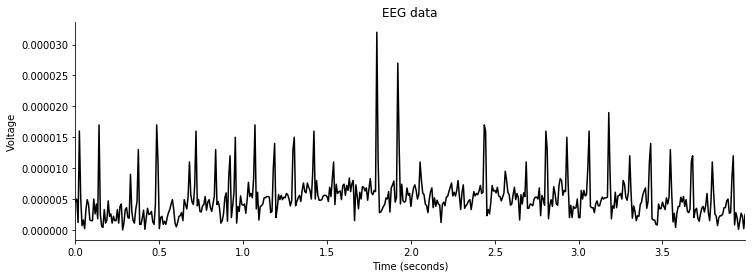

In [754]:
signal = xtrain_emg.iloc[14000,:].values
# Define sampling frequency and time vector
sf = 128.
time = np.arange(signal.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, abs(signal), lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('EEG data')
sns.despine()

# Functions for Feature Extraction

In [776]:
###############################################################################
###############################################################################
'''  ## EEG FEATURES ##   '''
###############################################################################
###############################################################################

'''NOTE TO SELF: remember to chance features_num whenever playing around with features'''
'''extracting bandpower from eeg signal'''

# Note that yasa's bandpower function limits the row length to the amount of columns divided by 2
# Therefore, iterate in for loop 100 rows at a time

def extract_bandpower_eeg(signal, frequency = 128):
    for i in (np.arange(signal.shape[0] / 100) + 1):
        if i == 1:
            df = yasa.bandpower(signal.iloc[0:int(100*i),:].values, sf=frequency)
        else:
            df = df.append(yasa.bandpower(signal.iloc[int(100*(i-1)):int(100*i),:].values, sf=frequency))
    
    df = df.set_index(np.arange(signal.shape[0]))
    df = df.drop(columns = ["FreqRes","Relative"], axis = 1)
    return df

###############################################################################

'''extracting descriptive statistics for eeg signals'''

def descriptive_statistics_EEG(signal, fs = 128):
    K_boundary = 10         # to be tuned
    t_fisher = 12          # to be tuned
    d_fisher = 40          # to be tuned
    features_num = 7
    threshold =  0.0009
   
    '''simple statistics'''
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(signal.shape) > 1) and (signal.shape[1]!=1):
        simple_stats = np.array([np.mean(signal, axis=1), 
                        np.median(signal, axis=1),
                        np.std(signal, axis=1), 
                        np.max(signal, axis=1),
                        np.min(signal, axis=1), 
                        kurtosis(signal, axis=1),
                        skew(signal, axis=1), 
                        pd.Series(np.sum(np.abs(signal), axis = 1))]).T
                        
    else:
        print("Not Tested with this input!")
        simple_stats =  np.array([np.mean(signal), 
                        np.median(signal), 
                        np.std(sigal),
                        np.max(signal), 
                        np.min(signal), 
                        float(kurtosis(signal)),
                        float(skew(signal))])
        
        
    '''Advanced statistics: Higuchi Fractal Dimension, Fisher Infromation,
    Petrosian Fractal Dimension, Detrended Fluctuation Analysis'''
        
    advanced_stats = np.zeros((signal.shape[0],features_num))
    for i in tqdm((np.arange(signal.shape[0]))):
        feat_array = np.array([
                               pyeeg.fisher_info(signal.iloc[i,:], t_fisher, d_fisher), 
                               pyeeg.pfd(signal.iloc[i,:]), 
                               pyeeg.dfa(signal.iloc[i,:]),
                               pyeeg.hfd(signal.iloc[i,:], K_boundary),
                               np.sum((abs(signal.iloc[i,:]) ** (-0.3)).values > 20),
                               np.sum((abs(signal.iloc[i,:])).values > threshold),
                               np.std(abs(signal.iloc[i,:].values) ** (0.05))])
        advanced_stats[i, :] = feat_array 

    union_smpl_adv = np.concatenate((simple_stats, advanced_stats), axis = 1)

    return (union_smpl_adv)

###############################################################################

'''joining bandpower and descriptive statistics'''

def EEG_feature_extraction(signal, fs = 128): 
    eeg_features = np.concatenate((extract_bandpower_eeg(signal, 128), descriptive_statistics_EEG(signal, fs = 128)), axis = 1)
    
    return(eeg_features)



###############################################################################
###############################################################################
'''  ## EMG FEATURES ##   '''
###############################################################################
###############################################################################

'''extracting descriptive statistics for emg signals'''

def EMG_feature_extraction(signal, fs = 128):
    features_num = 6
    
    '''simple statistics'''
    """ TESTED for (nxd) matrix input """
    # Check if it is not a 1d array
    if (len(signal.shape) > 1) and (signal.shape[1]!=1):
        simple_stats = np.array([np.mean(signal, axis=1), 
                        np.median(signal, axis=1),
                        np.std(signal, axis=1), 
                        np.max(signal, axis=1),
                        np.min(signal, axis=1), 
                        kurtosis(signal, axis=1),
                        skew(signal, axis=1), 
                        pd.Series(np.sum(np.abs(signal), axis = 1))]).T
                        
    else:
        print("Not Tested with this input!")
        simple_stats =  np.array([np.mean(signal), 
                        np.median(signal), 
                        np.std(sigal),
                        np.max(signal), 
                        np.min(signal), 
                        float(kurtosis(signal)),
                        float(skew(signal))])

    '''
    TO BE UPDATED:
    Advanced statistics -- these include: 
    Median values for second, third, fourth and fifth powers of initial emg signal,
    Median of changes in amplitude, 
    Std of changes in amplitude, 
    Lengths of waves, 
    Mean of squared differences of emg signal
    '''
    advanced_stats = np.zeros((signal.shape[0],features_num))
    for i in tqdm((np.arange(signal.shape[0]))):
        feat_array = np.array([
                              np.median(signal.iloc[i,:] ** 2), 
                              #np.median(signal.iloc[i,:] ** 3), 
                              np.median(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.std(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.sum(np.abs(np.diff(signal.iloc[i,:]))), 
                              np.mean(np.power(np.diff(signal.iloc[i,:]), 2)),
                              np.std(abs(signal.iloc[i,:].values))])
        advanced_stats[i, :] = feat_array 
        
        union_smpl_adv = np.concatenate((simple_stats, advanced_stats), axis = 1)

    return(union_smpl_adv)


# Feature Extraction

In [773]:
'''added to conduct some experiments  --- training of 1st subj and testing on 2nd subj'''
'''create training data'''

subj1_eeg1 = xtrain_eeg1.iloc[0:21599,:]
subj1_eeg2 = xtrain_eeg2.iloc[0:21599,:]
subj1_emg = xtrain_emg.iloc[0:21599,:]
ytrain_subj1 = ytrain.iloc[0:21599,:]

xtrain_subj1_eeg_1 = EEG_feature_extraction(subj1_eeg1, 128)  #take the whole xtrain in place of subj1_eeg1
xtrain_subj1_eeg_2 = EEG_feature_extraction(subj1_eeg2, 128)
xtrain_subj1_emg = EMG_feature_extraction(subj1_emg, 128)
xtrain_subj1 = np.concatenate((xtrain_subj1_eeg_1, xtrain_subj1_eeg_2, xtrain_subj1_emg), axis = 1)

print(xtrain_subj1_eeg_1.shape, xtrain_subj1_eeg_2.shape, xtrain_subj1_emg)
print(xtrain_subj1.shape)

'''creating test data'''

subj2_eeg1 = xtrain_eeg1.iloc[21600:43199,:]
subj2_eeg2 = xtrain_eeg2.iloc[21600:43199,:]
subj2_emg = xtrain_emg.iloc[21600:43199,:]
ytest_subj2 = ytrain.iloc[21600:43199,:]

xtest_subj2_eeg_1 = EEG_feature_extraction(subj2_eeg1, 128)
xtest_subj2_eeg_2 = EEG_feature_extraction(subj2_eeg2, 128)
xtest_subj2_emg = EMG_feature_extraction(subj2_emg, 128)
xtest_subj2 = np.concatenate((xtest_subj2_eeg_1, xtest_subj2_eeg_2, xtest_subj2_emg), axis = 1)


(21599, 19) (21599, 19) [[-1.08082031e-05 -1.00000000e-05  1.03004708e-05 ...  4.16320000e-03
   1.64071076e-10  9.52993407e-06]
 [-1.05593750e-05 -9.50000000e-06  9.00428446e-06 ...  3.68040000e-03
   1.29920352e-10  8.58781155e-06]
 [-9.91113281e-06 -9.20000000e-06  8.31664447e-06 ...  3.34400000e-03
   1.01551076e-10  7.46010959e-06]
 ...
 [-4.88320313e-06 -4.50000000e-06  5.13549907e-06 ...  2.36480000e-03
   4.48091977e-11  4.63503621e-06]
 [-5.05625000e-06 -4.60000000e-06  4.67491644e-06 ...  2.17370000e-03
   3.36606067e-11  4.14632227e-06]
 [-4.96660156e-06 -4.75000000e-06  4.44436504e-06 ...  2.09590000e-03
   3.33125049e-11  3.80641327e-06]]
(21599, 51)


# Experiments on Features

In [774]:
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score

clf = svm.SVC(kernel='rbf', C = 0.3, gamma = 'auto', class_weight = 'balanced')
scaler = preprocessing.StandardScaler()

xtrain_subj1_rescaled = scaler.fit_transform(xtrain_subj1)
xtest_subj2 = scaler.fit_transform(xtest_subj2)

clf.fit(xtrain_subj1_rescaled, ytrain_subj1)
ypred = clf.predict(xtest_subj2)

BMAC = balanced_accuracy_score(ytest_subj2, ypred)

print(BMAC)

C:\Users\Nicolò Grometto\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9457852577539478


# Experiments for Submission -- main part follows

In [ ]:
'''prepare training data'''

xtrain_trial_eeg_1 = EEG_feature_extraction(xtrain_eeg1, 128)  #take the whole xtrain in place of subj1_eeg1
xtrain_traial_eeg_2 = EEG_feature_extraction(xtrain_eeg2, 128)
xtrain_trial_emg = EMG_feature_extraction(xtrain_emg, 128)
xtrain_trial = np.concatenate((xtrain_trial_eeg_1, xtrain_traial_eeg_2, xtrain_trial_emg), axis = 1)

'''prepare test data'''

xtest_trial_eeg_1 = EEG_feature_extraction(xtest_eeg1, 128)  #take the whole xtrain in place of subj1_eeg1
xtest_trial_eeg_2 = EEG_feature_extraction(xtest_eeg2, 128)
xtest_trial_emg = EMG_feature_extraction(xtest_emg, 128)
xtest_trial = np.concatenate((xtest_trial_eeg_1, xtest_trial_eeg_2, xtest_trial_emg), axis = 1)


'''train and predict'''

clf = svm.SVC(kernel='rbf', C = 0.3, gamma = 'auto', class_weight = 'balanced')
scaler = preprocessing.StandardScaler()

xtrain_trial_rescaled = scaler.fit_transform(xtrain_trial)
xtest_trial_rescaled = scaler.fit_transform(xtest_trial)

clf.fit(xtrain_trial_rescaled, ytrain)
ypred = clf.predict(xtest_trial_rescaled)

index = pd.read_csv("sample.csv")
index['y'] = ypred
index.to_csv("trail_svc_feature_extraction.csv")

# Model Selection -- Grid Search CV

In [779]:
#############################################################################
'''prepare training data'''
#############################################################################

xtrain_eeg1_processed = EEG_feature_extraction(xtrain_eeg1, 128)
xtrain_eeg2_processed = EEG_feature_extraction(xtrain_eeg2, 128)
xtrain_emg_processed = EMG_feature_extraction(xtrain_emg, 128)
xtrain = np.concatenate((xtrain_eeg1_processed, 
                         xtrain_eeg2_processed, 
                         xtrain_emg_processed), 
                         axis = 1)
print(xtrain.shape)



(64800, 54)


In [781]:
#############################################################################
'''perform grid search'''
#############################################################################

steps = [("scaler", StandardScaler()), ("classifier", SVC())]
pipeline = Pipeline(steps = steps)

parameters = {"classifier__kernel": ["rbf"],
              "classifier__gamma": ["auto"],
              "classifier__C": [0.1, 0.3, 0.5, 0.7],  
              "classifier__class_weight": ["balanced"]
             }
grid = GridSearchCV(pipeline, parameters, cv = 3, scoring = 'balanced_accuracy', verbose = 1)

grid.fit(xtrain, ytrain.values.ravel())
print(grid.best_score_)
print(grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  6.8min finished


0.9198817939813404
{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


# Make Submission

In [ ]:
##############################################################################
'''prepare test data'''
##############################################################################

xtest_eeg1_processed = EEG_feature_extraction(xtest_eeg1, 128)
xtest_eeg2_processed = EEG_feature_extraction(xtest_eeg2, 128)
xtest_emg_processed = EMG_feature_extraction(xtest_emg, 128)
xtest = np.concatenate((xtest_eeg1_processed, 
                         xtest_eeg2_processed, 
                         xtest_emg_processed), 
                         axis = 1)
print(xtest.shape)

##############################################################################
'''train and predict'''
##############################################################################

clf = svm.SVC(kernel='rbf', C = 0.1, gamma = 'auto', class_weight = 'balanced')
scaler = preprocessing.StandardScaler()

xtrain_rescaled = scaler.fit_transform(xtrain)
xtest_rescaled = scaler.fit_transform(xtest)

clf.fit(xtrain_rescaled, ytrain)
ypred = clf.predict(xtest_rescaled)

index = pd.read_csv("sample.csv")
index['y'] = ypred
index.to_csv("trail_svc_feature_extraction.csv")

C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\pyeeg\detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\pyeeg\detrended_fluctuation_analysis.py:131: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ).T, numpy.log(F))[0][0]
C:\Users\Nicolò Grometto\AppData\Roaming\Python\Python37\site-packages\pyeeg-0.4.4-py3.7.egg\py